In [1]:
import sys

# Conda enviroment paths
sys.path.append('/home/vicente/anaconda3/envs/freecad-env/lib')
sys.path.append('/home/vicente/anaconda3/envs/freecad-env/Mod/Fem')

import ObjectsFem
import FreeCAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
doc_name = 'cir_1250'
doc = FreeCAD.open(f'files/{doc_name}/{doc_name}_mech.FCStd')

results_obj = doc.getObject('CCX_Results')
mesh_obj = doc.getObject('MeshGmsh')
model_obj = doc.getObject('Container')

# Isometric view plots

In [3]:
outer_faces_cir = [1, 2] # Face-3: Bottom; Face-2: Top
outer_faces_hex = [2, 1, 3, 7, 8, 6, 5] # Face-4: Bottom; Face-5: Top

nodes_dict = dict(mesh_obj.FemMesh.Nodes)

all_faces_nodes_coords = []
all_faces_von_mises = []
all_faces_displacement = []
all_faces_strain = []

for nFace in outer_faces_cir:

    face_idx = mesh_obj.FemMesh.getFacesByFace(model_obj.Shape.Faces[nFace-1])
    faces_nodes_coords, von_mises, displacement, strain = [], [], [], []
    
    for idx_f in face_idx:
        nodes_idx = mesh_obj.FemMesh.getElementNodes(idx_f)
        nodes_coords = [nodes_dict[idx_n] for idx_n in nodes_idx]
        
        von_mises_mean = np.mean([results_obj.vonMises[idx_n-1] for idx_n in nodes_idx])
        displacement_mean = np.mean([results_obj.DisplacementLengths[idx_n-1] for idx_n in nodes_idx])
        strain_mean = 0
        for idx_n in nodes_idx:
            xx = results_obj.NodeStrainXX[idx_n-1]; xy = results_obj.NodeStrainXY[idx_n-1]
            xz = results_obj.NodeStrainXZ[idx_n-1]; yy = results_obj.NodeStrainYY[idx_n-1]
            yz = results_obj.NodeStrainYZ[idx_n-1]; zz = results_obj.NodeStrainZZ[idx_n-1]
            strain_mean += np.sqrt(xx**2 + yy**2 + zz**2 + 2*(xy**2 + xz**2 + yz**2))
        strain_mean /= len(nodes_idx)
        
        faces_nodes_coords.append(nodes_coords)
        von_mises.append(von_mises_mean)
        displacement.append(displacement_mean)
        strain.append(strain_mean)

    all_faces_nodes_coords.append(faces_nodes_coords)
    all_faces_von_mises.append(von_mises)
    all_faces_displacement.append(displacement)
    all_faces_strain.append(strain)

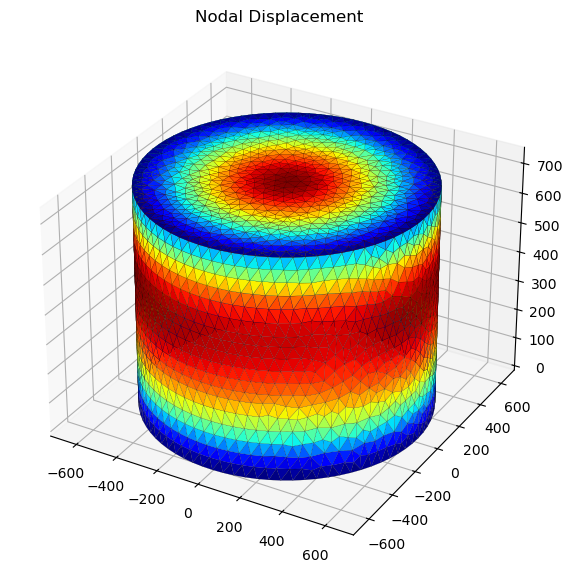

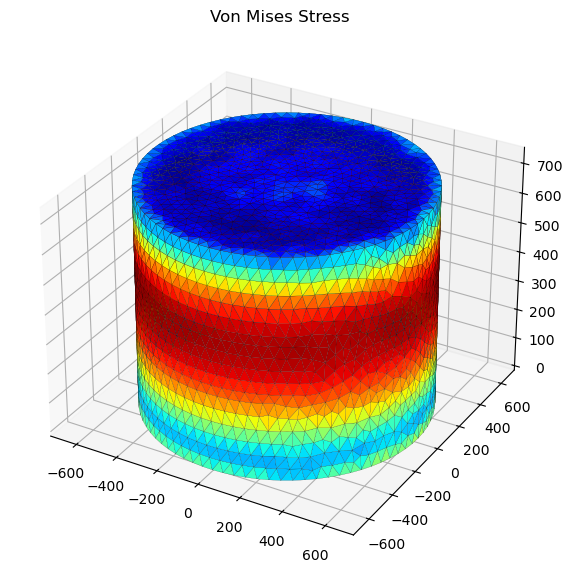

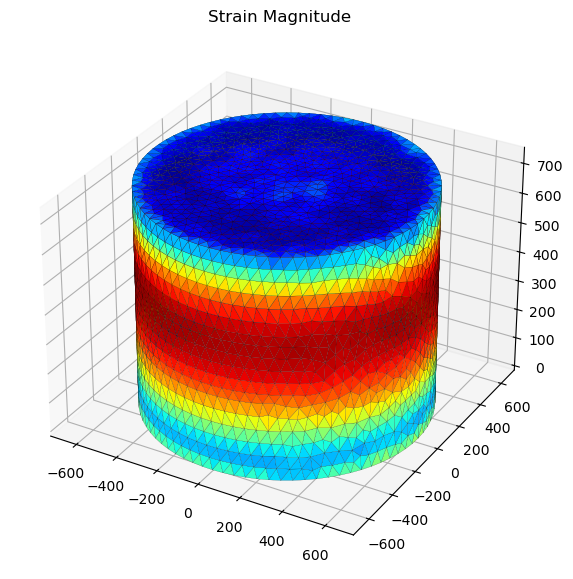

In [6]:
cmap = plt.get_cmap('jet')

# DISPLACEMENT

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

norm = mcolors.Normalize(vmin=np.min(displacement), vmax=np.max(displacement))
for faces_nodes_coords, displacement in zip(all_faces_nodes_coords, all_faces_displacement):
    norm = mcolors.Normalize(vmin=min(displacement), vmax=max(displacement))
    poly3d = Poly3DCollection(faces_nodes_coords, facecolors=cmap(norm(displacement)), linewidths=.1, edgecolors='k')
    ax.add_collection3d(poly3d)

plt.title('Nodal Displacement')
plt.show()

# VON MISES

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

norm2 = mcolors.Normalize(vmin=np.min(von_mises), vmax=np.max(von_mises))
for faces_nodes_coords, von_mises in zip(all_faces_nodes_coords, all_faces_von_mises):
    poly3d = Poly3DCollection(faces_nodes_coords, facecolors=cmap(norm2(von_mises)), linewidths=.1, edgecolors='k')
    ax.add_collection3d(poly3d)

plt.title('Von Mises Stress')
plt.show()

# STRAIN

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

norm3 = mcolors.Normalize(vmin=np.min(strain), vmax=np.max(strain))
for faces_nodes_coords, strain in zip(all_faces_nodes_coords, all_faces_strain):
    poly3d = Poly3DCollection(faces_nodes_coords, facecolors=cmap(norm3(strain)), linewidths=.1, edgecolors='k')
    ax.add_collection3d(poly3d)

plt.title('Strain Magnitude')
plt.show()

# Histograms

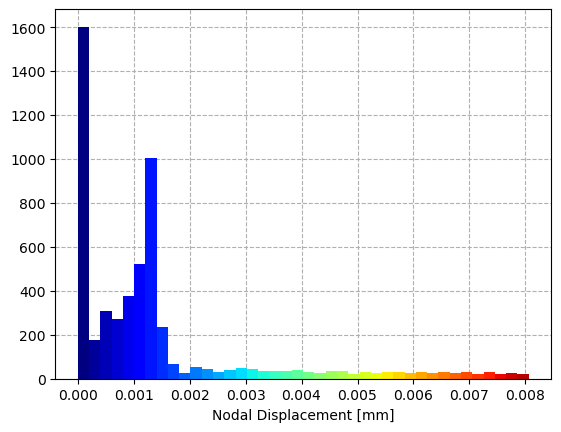

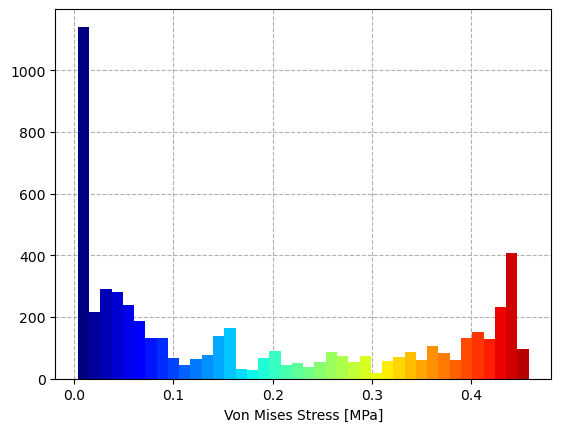

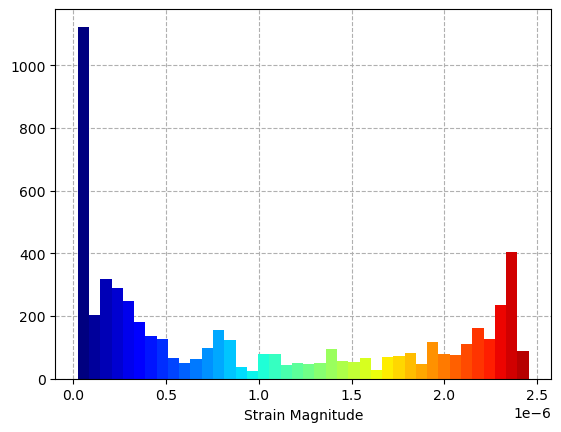

In [5]:
# DISPLACEMENT

displacement = results_obj.DisplacementLengths

cnts, values, bars = plt.hist(displacement, bins=40)
for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
    bar.set_facecolor(cmap(i/len(values)))

plt.xlabel('Nodal Displacement [mm]')
plt.grid(ls='--')
plt.gca().set_axisbelow(True)

plt.show()

# VON MISES

von_mises = results_obj.vonMises

cnts, values, bars = plt.hist(von_mises, bins=40)
for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
    bar.set_facecolor(cmap(i/len(values)))

plt.xlabel('Von Mises Stress [MPa]')
plt.grid(ls='--')
plt.gca().set_axisbelow(True)

plt.show()

# STRAIN

xx = np.array(results_obj.NodeStrainXX); xy = np.array(results_obj.NodeStrainXY)
xz = np.array(results_obj.NodeStrainXZ); yy = np.array(results_obj.NodeStrainYY)
yz = np.array(results_obj.NodeStrainYZ); zz = np.array(results_obj.NodeStrainZZ)
strain = np.sqrt(xx**2 + yy**2 + zz**2 + 2*(xy**2 + xz**2 + yz**2))

cnts, values, bars = plt.hist(strain, bins=40)
for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
    bar.set_facecolor(cmap(i/len(values)))

plt.xlabel('Strain Magnitude')
plt.grid(ls='--')
plt.gca().set_axisbelow(True)

plt.show()